In [1]:
import keras

keras.__version__

Using TensorFlow backend.


'2.2.4'

# Chap07 - 딥러닝을 위한 고급 도구

## Goals

- Keras의 함수형 API (Function API)

- Keras의 Callback 사용 방법
 
- 시각화 도구인 텐서보드 사용 방법

- 최고 수준의 모델을 만들기 위한 모범 사례

## 7.1 Sequential 모델을 넘어서: 케라스의 함수형 API

- [`Sequential`](https://keras.io/models/sequential/) 모델은 네트워크 입력과 출력이 하나라고 가정한다.

![](./images/sequential.png)

- `Sequential` 모델 클래스는 다음의 상황에는 사용하기 부적합하다.

    - 여러 개의 (개별)입력이 필요한 경우
    
    - 여러 개의 출력이 필요한 경우
    
    - 층(layer)을 차례대로 쌓지 않고 층 사이를 연결하여 그래프처럼 만드는 네트워크

- Function(함수형) API를 이용하면 위의 모델을 구현할 수 있다.

![](./images/multi-io.png)

---

![](./images/inception-res.png)

### 7.1.1 함수형 API 소개

- [**함수형 API**](https://keras.io/getting-started/functional-api-guide/)(functional API)에서는 직접 텐서들의 입출력을 다룬다.

- 함수처럼 층을 사용하여 텐서를 입력받고 출력한다. 

- 파이썬에는 클래스 객체를 함수처럼 호출할 수 있는 매직 메서드(던더 메서드) `__call__()`메서드를 이용한다.

In [2]:
from keras import Input, layers

input_tensor = Input(shape=(32,))  # 텐서
dense = layers.Dense(32, activation='relu')  # 함수처럼 사용하기 위해 층 객체를 만듦

output_tensor = dense(input_tensor)  # 텐서와 함께 층을 호출하면 텐서를 반환한다.
output_tensor

<tf.Tensor 'dense_1/Relu:0' shape=(?, 32) dtype=float32>

#### `Sequential` 모델과 함수형 API 비교

In [3]:
from keras.models import Sequential, Model
from keras import layers
from keras import Input
from keras import backend as K

In [4]:
##############
# Sequential #
##############
K.clear_session()

seq_model = Sequential()
seq_model.add(layers.Dense(32, activation='relu', input_shape=(64,)))
seq_model.add(layers.Dense(32, activation='relu'))
seq_model.add(layers.Dense(10, activation='softmax'))
seq_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                330       
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________


In [5]:
##################
# Functional API #
##################
input_tensor = Input(shape=(64,))
x = layers.Dense(32, activation='relu')(input_tensor)
x = layers.Dense(32, activation='relu')(x)
output_tensor = layers.Dense(10, activation='softmax')(x)

# 입력과 출력 텐서를 지정하여 Model 클래스의 객체를 만듦
model = Model(input_tensor, output_tensor)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                330       
Total params: 3,466
Trainable params: 3,466
Non-trainable params: 0
_________________________________________________________________


- 케라스는 `input_tensor`에서 `output_tensor`로 출력되는 데 까지 필요한 모든 층을 추출한 뒤 `Model`객체를 만든다.

- `input_tensor`를 반복 변환하여 `output_tensor`를 만들 수 있어야 한다.

### 7.1.2 다중 입력 모델 (Multi-Input Model)

- 함수형 API는 다중 입력 모델(multi-input model)을 만드는 데 사용할 수 있다.

- 일반적으로 서로 다른 입력을 합치기 위해 여러 텐서를 연결할 수 있는 층(layer)를 사용한다. → [[링크](https://keras.io/layers/merge/)]참고

    - `keras.layers.add`, `keras.layers.concatenate` 등이 있다.
    
   
- 예를 들어, 질문-응답(question-answering) 모델을 다음과 같이 구성할 수 있다.

![](./images/multi-input.png)

#### 질문-응답 모델의 함수형 API 구현

In [7]:
from keras.models import Model
from keras import layers
from keras import Input

In [13]:
K.clear_session()

text_vocabulary_size = 10000
question_vocabulary_size = 10000
answer_vocabulary_size = 500

# 텍스트 입력은 길이가 정해지지 않은 정수 시퀀스
text_input = Input(shape=(None,), dtype='int32', name='text')
# 입력을 shape이 64인 벡터의 시퀀스로 임베딩
embedded_text = layers.Embedding(text_vocabulary_size, 64)(text_input)
# LSTM을 사용하여 하나의 벡터로 인코딩
encoded_text = layers.LSTM(32)(embedded_text)

question_input = Input(shape=(None,), dtype='int32', name='question')
embedded_question = layers.Embedding(text_vocabulary_size, 64)(question_input)
# LSTM을 사용하여 하나의 벡터로 인코딩
encoded_question = layers.LSTM(32)(embedded_question)

# 인코딩된 질문과 텍스트를 연결한다.
# concatenated = layers.Concatenate(axis=-1)([encoded_text, encoded_question])
concatenated = layers.concatenate([encoded_text, encoded_question], axis=-1)

# 소프트맥스 분류기 추가
answer = layers.Dense(answer_vocabulary_size, 
                      activation='softmax')(concatenated)

# 모델 객체를 만들고 2개의 입력과 출력을 주입
model = Model([text_input, question_input], answer)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               (None, None)         0                                            
__________________________________________________________________________________________________
question (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     640000      text[0][0]                       
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     640000      question[0][0]                   
__________________________________________________________________________________________________
lstm_1 (LS

#### Multi-Input 모델에 데이터 주입하기

In [16]:
import numpy as np
from keras.utils import to_categorical

num_samples = 1000
max_length = 100

text = np.random.randint(1, text_vocabulary_size,
                         size=(num_samples, max_length))
question = np.random.randint(1, question_vocabulary_size,
                         size=(num_samples, max_length))

answers = np.random.randint(0, answer_vocabulary_size, size=num_samples)
answers = to_categorical(answers)  # One-hot

# 리스트 입력을 사용하여 학습
model.fit([text, question], answers, epochs=10, batch_size=128)

# # 입력에 이름(name)을 지정했을 때만 사용가능
model.fit({'text': text, 'question': question}, answers,
          epochs=10, batch_size=128)

### 7.1.3 다중 출력 모델 (Multi-Output Model)

- 7.1.2에서 처럼 함수형 API를 사용해 **다중 출력** 모델을 만들 수 있다.

- 예를 들어, 소셜 미디어에서 익명 사용자의 포스트를 입력으로 받아 그 사람의 나이, 성별, 소득 수준을 예측하는 모델을 다음과 같이 만들 수 있다.

![](./images/multi-output.png)

#### 3개의 출력을 가진 함수형API 구현하기

In [17]:
from keras import layers
from keras import Input
from keras.models import Model

In [19]:
K.clear_session()

vocabulary_size = 50000
num_income_groups = 10

posts_input = Input(shape=(None,), dtype='int32', name='posts')
embedded_posts = layers.Embedding(vocabulary_size, 256)(posts_input)
x = layers.Conv1D(128, 5, activation='relu')(embedded_posts)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.Conv1D(256, 5, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation='relu')(x)

# 출력 층에 이름을 지정
age_prediction = layers.Dense(1, name='age')(x)
income_prediction = layers.Dense(num_income_groups,
                                 activation='softmax',
                                 name='income')(x)
gender_prediction = layers.Dense(1, activation='sigmoid', name='gender')(x)

model = Model(posts_input,
              [age_prediction, income_prediction, gender_prediction])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
posts (InputLayer)              (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 256)    12800000    posts[0][0]                      
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 128)    163968      embedding_1[0][0]                
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, None, 128)    0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (

#### Multi-Output Model의 `compile` 옵션 (1) : 다중 손실

- 다중 출력 모델을 훈련하려면 네트워크 출력마다 다른 손실 함수를 지정해야 한다.

- 위의 예제에서는 각 네트워크 출력에 따른 손실함수를 다음과 같이 지정해줘야 한다.

    - 나이 예측은 스칼라 회귀 문제 → `mse`
    - 성별 예측은 이진 클래스 문제 → `binary_crossentropy`
    - 소득 수준은 다중 클래스 문제 → `categorical_crossentropy`
    

- 경사 하강법(GD)은 하나의 스칼라 값, 즉 하나의 손실 값을 최소하하기 때문에 모델을 훈련하려면 각 출력에 대한 손실들을 **하나의 값으로 합쳐**줘야 한다. 
    - 손실 값을 합치는 가장 간단한 방법은 모두 더하는 것이다.


- 케라스에서는 `compile()`메서드에 리스트나 딕셔너리를 사용하여 출력마다 다른 손실을 지정할 수 있다.
    - 계산된 손실 값은 하나의 전체 손실로 더해지고 훈련을 통해 최소화 된다.

In [20]:
# 리스트 형태
model.compile(optimizer='rmsprop',
              loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'])

# 딕셔너리 형태: 출력 층에 이름을 지정해야함
model.compile(optimizer='rmsprop', 
              loss={'age': 'mse',
                    'income': 'categorical_crossentropy',
                    'gender': 'binary_crossentropy'})

#### Multi-Output Model의 `compile` 옵션 (2) : 손실 가중치

- 손실(loss)값이 많이 불균형하면 모델이 개별 손실이 가장 큰 작업에 치우쳐 표현을 최적화한다.

- 이를 해결하기 위해, 각 출력의 손실 값이 최종 손실에 기여하는 수준을 지정할 수 있다.


- 특히 손실 값의 **스케일**이 다를 때 유용하다.
    - MSE는 일반적으로 3~5 사이의 값을 가지고, CEE는 0.1정도이기 때문에 CEE에는 가중치 10을 주고, MSE에는 가중치 0.25로 설정해 줄 수 있다.  

In [21]:
# 리스트 형태
model.compile(optimizer='rmsprop',
              loss=['mse', 'categorical_crossentropy', 'binary_crossentropy'],
              loss_weights=[0.25, 1., 10])

# 딕셔너리 형태: 출력 층에 이름을 지정해야함
model.compile(optimizer='rmsprop', 
              loss={'age': 'mse',
                    'income': 'categorical_crossentropy',
                    'gender': 'binary_crossentropy'},
              loss_weights={'age': 0.25,
                            'income': 1.,
                            'gender': 10.})

#### Multi-Output Model에 데이터 주입하기

- Multi-Input 모델과 마찬가지로 넘파이(NumPy) 배열의 리스트나 딕셔너리를 모델에 전달하여 훈련한다.


```python
# 리스트 형태
model.fit(posts, [age_targets, income_targets, gender_targets],
          epochs=10, batch_size=64)

# 딕셔너리 형태 : 출력 층에 이름을 지정해야 함
model.fit(posts, {'age': age_targets,
                  'income': income_targets,
                  'gender': gender_targets},
          epochs=10, batch_size=64)
```

### 7.1.4 층으로 구성된 비순환 유향 그래프

- 함수형 API를 사용하면 다중 입력이나 다중 출력 모델뿐만 아니라 내부 [토폴로지](https://ko.wikipedia.org/wiki/%EB%84%A4%ED%8A%B8%EC%9B%8C%ED%81%AC_%ED%86%A0%ED%8F%B4%EB%A1%9C%EC%A7%80)가 복잡한 네트워크도 만들 수 있다.

- 케라스의 신경망은 층으로 구성된 어떠한 **비순환 유향 그래프**(directed acyclic graph)를 만들 수 있다. 

- 그래프로 구현된 신경망 컴포넌트 중 유명한 2개는 **인셉션 모듈(Inception module)**과 **잔차 연결(residual connection)**이다.

#### 인셉션 모듈

- [**인셉션(Inception)**](https://arxiv.org/abs/1409.4842)은 합성곱 신경망에서 인기 있는 네트워크 구조이다.

- **네트워크 안의 네트워크**(NiN, Network-in-Network) 구조에서 영감을 받아 Szegedy 등이 만들었다.


- 가장 기본적인 인셉션 모듈 형태는 3~4개의 가지를 가진다.

    - $1 \times 1$ 합성곱으로 시작해서 $3 \times 3$ 합성곱 다음 마지막 전체 출력 특성이 합쳐진다.
    
        - 일부 가지에서는 $3 \times 3$ 대신 $5 \times 5$를 사용하기도 한다.
    
    
    - 이러한 구성은 네트워크가 따로따로 공간 특성과 채널 방향의 특성을 학습하도록 해준다.
    
- **인셉션 V3**([Inception V3](https://arxiv.org/abs/1512.00567))의 구조는 다음과 같다.

![](./images/inception-v3.png)

> $1 \times 1$ **합성곱의 목적**
 - 입력 텐서의 채널(channel) 또는 depth 정보를 혼합한 특성을 계산하며, **공간 방향**으로는 정보를 섞지 않는다. 
 - 채널(depth) 방향의 특성 학습과 공간 방향의 특성 학습을 분리하는 데 도움을 준다.
 - 채널(depth)의 차원을 줄이는 데 사용한다.


![](./images/bottleneck.png)

![](./images/inception-v3-02.png)

#### 함수형 API를 이용해 인셉션 모듈 구현하기

In [7]:
from keras import Input
from keras import layers
from keras import Model
from keras import backend as K

In [8]:
K.clear_session()

inputs = Input(shape=(28, 28, 256), dtype='float32', name='inception_input')

# 모든 가지는 동일한 스트라이드(2)를 사용 
#   → 출력 크기를 동일하게 만들어 하나로 합치기 위함

branch_a = layers.Conv2D(128, 1, padding='same',
                         activation='relu', strides=2)(inputs)
 
branch_b = layers.Conv2D(128, 1, padding='same',
                         activation='relu')(inputs)
branch_b = layers.Conv2D(128, 3, padding='same',
                         activation='relu', strides=2)(branch_b)

branch_c = layers.AveragePooling2D(3, strides=2, padding='same')(inputs)
branch_c = layers.Conv2D(128, 3, padding='same', activation='relu')(branch_c)

branch_d = layers.Conv2D(128, 1, padding='same', activation='relu')(inputs)
branch_d = layers.Conv2D(128, 3, padding='same', activation='relu')(branch_d)
branch_d = layers.Conv2D(128, 3, padding='same', activation='relu', strides=2)(branch_d)

# Concatenate
concatenated = layers.concatenate([branch_a, branch_b, 
                                   branch_c, branch_d], axis=-1)
outputs = layers.Dense(10, activation='softmax')(concatenated)

model = Model(inputs, outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inception_input (InputLayer)    (None, 28, 28, 256)  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 128)  32896       inception_input[0][0]            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 128)  32896       inception_input[0][0]            
__________________________________________________________________________________________________
average_pooling2d_1 (AveragePoo (None, 14, 14, 256)  0           inception_input[0][0]            
__________________________________________________________________________________________________
conv2d_6 (

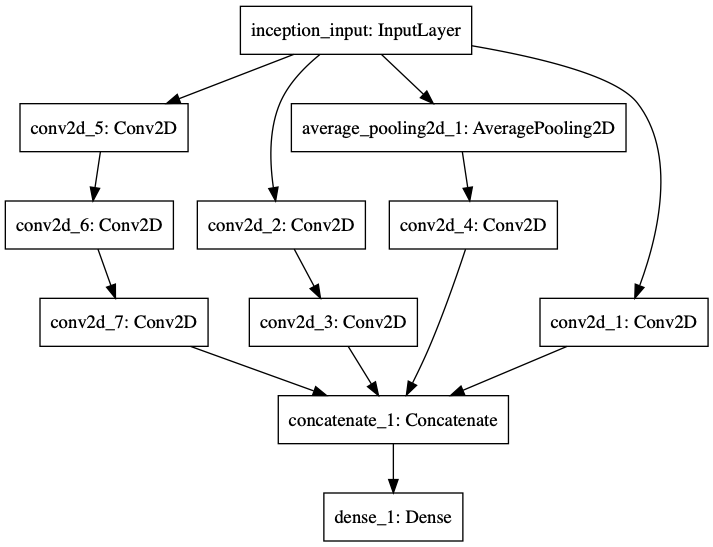

In [9]:
from IPython.display import Image
from keras.utils import plot_model

plot_model(model, to_file='./plot-model/inception-v3.png')
Image(filename='./plot-model/inception-v3.png')

- 인셉션 V3 전체 구조는 케라스의 `keras.application.inception_v3.InceptionV3`에 포함되어 있다.

- 인셉션 모델과 비슷한 모델인 [**엑셉션(Xception)**](https://arxiv.org/abs/1610.02357)도 케라스 애플리케이션 모듈에 포함되어 있다. 

    - 이 합성곱 구조는 인셉션에서 일부 영감을 받았다.
    
    - 채널(깊이) 방향의 학습과 공간 방향의 학습을 극단적으로 분리한다는 아이디어에 착안하여 인셉션 모듈을 깊이별 분리 합성곱으로 바꾼다.
    
    - 각 입력 채널(깊이)에 따로따로 적용되는 공간 방향 합성곱 다음에 $1 \times 1$ 합성곱을 적용한다.
    
    - 따라서, 공간 특성과 채널(깊이) 방향 특성을 완전히 분리한다.
    
    - keras에서 `layers.SeparableConv2D` 합성곱을 사용한다.
    
    - 엑셉션(Xception)은 Inception V3와 거의 동일한 개수의 파라밑를 가지지만 실행 속도가 더 빠르고, 대규모 데잍셋에서 정확도가 더 높다.
    
 
![](./images/depthwise.png)

#### 잔차 연결 (Residual Connection)

- 잔차 연결([residual connection](https://arxiv.org/abs/1512.03385))은 그래프 형태의 네트워크 컴포넌트다.


- 대규모 딥러닝 모델에서 흔히 나타나는 두 가지 문제인 **그래디언트 소실**과 **표현 병목(representational bottleneck)**을 해결 했다. 

    - 일반적으로 10개 층 이상을 가진 모델에 잔차 연결을 추가하면 도움이 된다.
    

- 잔차 연결은 하위 층의 출력을 상위층의 입력으로 사용한다.

- 하위 층의 출력이 상위 층의 활성화 출력에 연결되는 것이 아니고 더해지기 때문에, 두 출력의 크기가 동일해야 한다.


![](./images/resnet.png)

#### 함수형 API를 이용한 잔차 연결 구현

In [2]:
from keras import Input
from keras import layers
from keras import Model
from keras import backend as K

In [10]:
K.clear_session()

x = Input(shape=(28, 28, 128), name='mnist_input')
conv = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
conv = layers.Conv2D(128, 3, activation='relu', padding='same')(conv)

# residual connection
# = layers.Add()([conv, x])
residual = layers.add([conv, x])

# Activation
outputs = layers.Activation('relu')(residual)
outputs = layers.Flatten()(outputs)
outputs = layers.Dense(10, activation='softmax')(outputs)

# Model
model = Model(x, outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mnist_input (InputLayer)        (None, 28, 28, 128)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 128)  147584      mnist_input[0][0]                
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 128)  147584      conv2d_1[0][0]                   
__________________________________________________________________________________________________
add_1 (Add)                     (None, 28, 28, 128)  0           conv2d_2[0][0]                   
                                                                 mnist_input[0][0]                
__________

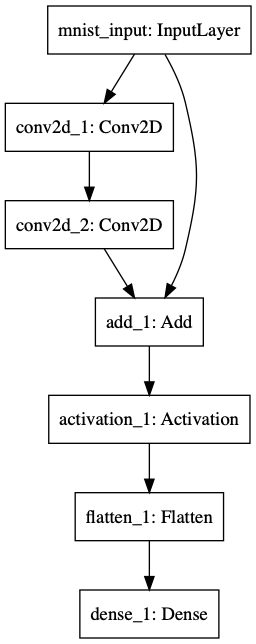

In [11]:
from IPython.display import Image
from keras.utils import plot_model

plot_model(model, to_file='./plot-model/resnet.png')
Image(filename='./plot-model/resnet.png')

### 7.1.5 층 가중치 공유

- 함수형 API는 층 객체를 여러 번 재사용할 수 있다. 

- 층 객체를 두 번 호출하면 새로운 층 객체를 만들지 않고 각 호출에 동일한 가중치를 재사용한다.

- 이를 이용해 공유 가지를 가진 모델을 만들 수 있다.

- 같은 표현을 공유하고 이런 표현을 다른 입력에서 함께 학습한다.

> 예를 들어, 두 문장 사이의 의미가 비슷한지 측정하는 모델을 가정해 보자.
> 이 모델은 2개의 입력(비교할 2개의 문장)을 받고 0과 1사이의 점수를 출력한다. 0은 관련없는 문장을 의미하고 1은 두 문장이 동일하거나 재구성되었다는 것을 의미한다.
- 이런 문제는 두 입력 시퀀스가 바뀔 수 있다. A에서 B에 대한 유사도는 B에서 A에 대한 유사도와 같다.
- 그러므로 각 입력 문장을 처리하는 2개의 독립된 모델을 학습하는 것 보다는 하나의 LSTM층으로 양쪽 모두를 처리하는 것이 좋다.
- 이 LSTM층의 가중치는 두 입력에 대해 함께 학습된다.
- 이를 **샴 LSTM(Siamese LSTM)** 모델 또는 **Shared LTSM** 이라고 한다.

> 이런 모델은 대화 시스템(dialog system)엣 자연어 질의에 대한 중복 제거를 포함하여 다양한 어플리케이션에 유용하게 사용될 수 있다.

In [13]:
from keras import layers
from keras import Input
from keras.models import Model
from keras import backend as K

In [16]:
K.clear_session()

# Input: 크기가 128인 벡터의 가변길이 시퀀스
left_input = Input(shape=(None, 128))
right_input = Input(shape=(None, 128))

# LSTM층 객체를 하나 만듦
lstm = layers.LSTM(32)

left_output = lstm(left_input)
right_output = lstm(right_input)

# Classifier
merged = layers.concatenate([left_output, right_output], axis=-1)
prediction = layers.Dense(1, activation='sigmoid')(merged)

model = Model([left_input, right_input], prediction)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 128)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 128)    0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 32)           20608       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 64)           0           lstm_1[0][0]                     
          

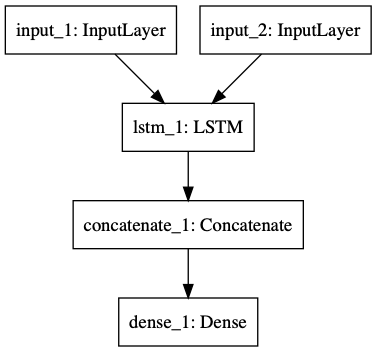

In [17]:
from IPython.display import Image
from keras.utils import plot_model

plot_model(model, to_file='./plot-model/shared-lstm.png')
Image(filename='./plot-model/shared-lstm.png')

### 7.1.6 층과 모델

- 함수형 API에서는 모델을 층처럼 사용할 수 있다. → 모델을 '커다란 층'으로 생각

```python
# 입력텐서로 모델을 호출해서 출력텐서를 얻을 수 있음
y = model(x)

# 입력 텐서와 출력텐서가 여러개면 텐서으 리스트로 호출
y1, y2 = model([x1, x2])
```

- 모델 객체를 호출할 때 모델의 가중치가 재사용된다.

- 층 객체나 모델 객체나 객체를 호출하는 것은 항상 그 객체가 가진 학습된 표현(가중치)을 재사용한다.

> 모델 객체를 재사용하는 간단한 실전 예는 듀얼 카메라에서 입력을 받는 비전 모델이다. 
> 두 카메라가 몇 센티미터(1인치) 간격을 두고 나란히 있고, 이런 모델은 깊이를 감지할 수 있다. 
> 왼쪽 카메라와 오른쪽 카메라에서 시각적 특징을 추출하여 합치기 위해 2개의 독립된 모델을 사용할 필요가 없다.
> 두 입력에 저수준 처리 과정이 공유될 수 있다. 다시 말해 가중치가 같고 동일한 표현을 공유하는 층을 사용한다. 


- 다음은 케라스에서 샴 비전 모델(공유 합성곱 기반 층)을 구현하는 예이다.

In [18]:
from keras import layers
from keras import applications
from keras import Input
from keras import backend as K

In [19]:
K.clear_session()

xception_base = applications.Xception(weights=None,
                                      include_top=False)

left_input = Input(shape=(250, 250, 3))
right_input = Input(shape=(250, 250, 3))

# 같은 비전 모델을 두 번 호출한다.
left_features = xception_base(left_input)
right_features = xception_base(right_input)

# 합쳐진 특성은 오른쪽 입력과 왼쪽 입력에서 얻은 정보를 담고 있다. 
merged_features = layers.concatenate([left_features, right_features], axis=-1)

### 7.1.7 정리

- 차례대로 층을 쌓는 것 이상이 필요할 때는 Sequential API를 사용하지 않는다.

- 함수형 API를 사용하여 다중 입력, 다중 출력, 복잡한 네트워크 토폴 로지를 갖는 케라스 모델을 만드는 방법

- 다른 네트워크 가지에서 같은 층이나 모델 객체를 여러 번 호출하여 가중치를 재사용하는 방법